### DWD AI TS (Thunderstorm)

This notebook loads and visualises the DWD AI TS (Thunderstorm) product over Africa.  
The TS field is a dimensionless (0–1) machine-learning–based thunderstorm severity index, provided at 15-minute temporal resolution with multiple time steps per file on a regular lat–lon grid.

In [1]:
import bz2
import tempfile
import os

import numpy as np 
from netCDF4 import Dataset, num2date
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

import cartopy.crs as ccrs                              
import cartopy.feature as cfeature                   
import cartopy.io.shapereader as shpreader

import warnings
warnings.filterwarnings("ignore")

--------------------------------------------------------------------------
detected:

  Local host:            host839
  Device name:           mlx5_bond_0
  Device vendor ID:      0x02c9
  Device vendor part ID: 4127

Default device parameters will be used, which may result in lower
performance.  You can edit any of the files specified by the
btl_openib_device_param_files MCA parameter to set values for your
device.

NOTE: You can turn off this warning by setting the MCA parameter
      btl_openib_warn_no_device_params_found to 0.
--------------------------------------------------------------------------
--------------------------------------------------------------------------
No OpenFabrics connection schemes reported that they were able to be
used on a specific port.  As such, the openib BTL (OpenFabrics
support) will be disabled for this port.

  Local host:           host839
  Local device:         mlx5_bond_0
  Local port:           1
  CPCs attempted:       rdmacm, udcm
-------

In [2]:
year = "2024"
month = "04"
day = "24"
hour = "06"
minute = "45"

In [3]:
path_TS = "/gws/ssde/j25b/swift/WISER-EWSA/DWD_AI_TS/data"

In [4]:
t = datetime(
    int(year), int(month), int(day),
    int(hour), int(minute)
)

date_str = t.strftime("%Y%m%d")

file_path = (
    f"{path_TS}/{date_str}/"
    f"TSfc{t:%Y%m%d%H%M}EA.nc.bz2"
)

In [5]:
with bz2.open(file_path, "rb") as f:
    decompressed = f.read()

with tempfile.NamedTemporaryFile(suffix=".nc", delete=False) as tmp:
    tmp.write(decompressed)
    tmp_path = tmp.name

ds = Dataset(tmp_path, mode="r")

In [6]:
print(ds.variables.keys())

dict_keys(['TS', 'time', 'lat', 'lon'])


In [7]:
print(ds.variables["TS"])

<class 'netCDF4._netCDF4.Variable'>
float64 TS(time, lat, lon)
    units: 1
    cell_methods: area: mean
    long_name: thunderstorm_severity
    scale_factor: 1.0
    valid_min: 0.0
    _FillValue: -0.01
    valid_max: 1.0
unlimited dimensions: 
current shape = (8, 1961, 1541)
filling on


In [8]:
ds.variables["time"]     # temporal res is 15 minutes, 900s

<class 'netCDF4._netCDF4.Variable'>
float32 time(time)
    units: seconds since 2024-04-24 06:50:00
    long_name: time UTC
    calender: proleptic_gregorian
    standard_name: time
unlimited dimensions: 
current shape = (8,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [9]:
ds.variables["lat"]

<class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    units: degrees_north
    long_name: latitude
    standard_name: latitude
unlimited dimensions: 
current shape = (1961,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [10]:
time_var = ds.variables["time"]
times = num2date(time_var[:], units=time_var.units)
ts = ds.variables["TS"][:]
lat = ds.variables["lat"][:]
lon = ds.variables["lon"][:]

In [11]:
print(time_var.shape, ts.shape, lat.shape, lon.shape)

(8,) (8, 1961, 1541) (1961,) (1541,)


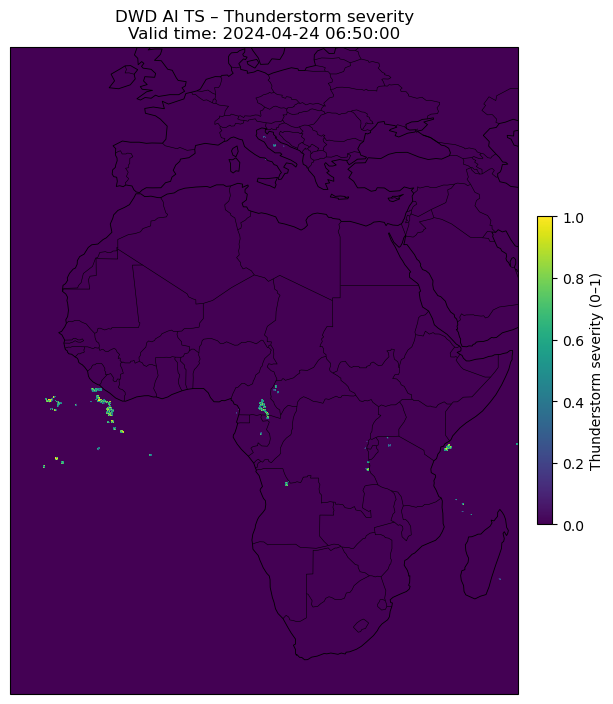

In [12]:
i = 0
ts_plot = ts[i]
ts_plot = np.where(ts_plot < 0, np.nan, ts_plot)

lon2d, lat2d = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent(
    [lon.min(), lon.max(), lat.min(), lat.max()],
    crs=ccrs.PlateCarree()
)

ax.coastlines(resolution="110m", linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)

im = ax.pcolormesh(
    lon2d,
    lat2d,
    ts_plot,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    vmin=0,
    vmax=1,
)

cbar = plt.colorbar(im, ax=ax, pad=0.03, shrink=0.4)
cbar.set_label("Thunderstorm severity (0–1)")

ax.set_title(f"DWD AI TS – Thunderstorm severity\nValid time: {times[i]}")

plt.show()
